# Example: mesh Wenas Hillslope, Yakima

Here we mesh the [Coweeta Hydrologic Laboratory](https://www.srs.fs.usda.gov/coweeta/) as an example of how to pull data in from default locations and generate a fully functional ATS mesh.

This might be the worst example to use to learn how to use Watershed Workflows.  But it is useful to demonstrate the breadth of problems this project was intended to solve.

This includes a range of datasets:

* National Hydrography Dataset (NHD) Plus for river network
* National Resources Conservation Service (NRCS) Soil Survey data for soil types
* National Land Cover Database (NLCD) for land cover/transpiration/rooting depths
* National Elevation Dataset (NED) for elevation/DEM

Watershed Workflow version: <branch: [mesh-custom-shape](https://github.com/pinshuai/watershed-workflow/tree/mesh-custom-shape), tag: >

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
# %matplotlib notebook

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [3]:
import os,sys
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as pcm
import shapely
import logging
import fiona
import rasterio
import scipy
import scipy.ndimage
import pandas as pd

In [4]:
import sys
sys.path.append("./")
# sys.path.append("/Users/shua784/Dropbox/github/watershed-workflow")
# sys.path.append("/Users/shua784/Dropbox/github/watershed-workflow/workflow_tpls")
# sys.path.append("/Users/shua784/Dropbox/github/watershed-workflow/workflow")
sys.path.append("/Users/shua784/Dropbox/github/seacas/install/lib")

sys.path.append("../../watershed-workflow")
sys.path.append("../workflow_tpls")
sys.path.append("../workflow")

In [5]:
import workflow
import workflow.source_list
import workflow.ui
import workflow.colors
import workflow.condition
import workflow.mesh
import workflow.split_hucs

workflow.ui.setup_logging(1,None)

In [226]:
watershed_name = "wenas_catchment"
meshRes = "10m"
fname_surface_mesh = f"./meshes/{watershed_name}_surface_mesh.vtk"
fname_final_mesh = f"./meshes/{watershed_name}_mesh-{meshRes}.exo"

In [7]:
# data_dir = "/Users/shua784/OneDrive - PNNL/Projects/Fraser_hillslope/data/"
bnd_shp = "../data/hydrologic_units/others/Wenas/wenas_catchment.shp"
# river_shp = data_dir + "GIS/shapefiles/SecondGrowth_trench/trench_line_UTM.shp"

# fname_dem = data_dir + "GIS/DEM/SecondGrowth.tif"
# fname_DTB = ""

## Import watershed boundary

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

In [8]:
# specify the input shapefile and a hint as to what HUC it is in.
logging.info("")
logging.info("Meshing shape: {}".format(bnd_shp))
logging.info("="*30)

# get the shape and crs of the shape
crs, watershed = workflow.get_split_form_shapes(bnd_shp)

2021-10-21 16:11:26,123 - root - INFO: 
2021-10-21 16:11:26,124 - root - INFO: Meshing shape: ../data/hydrologic_units/others/Wenas/wenas_catchment.shp
2021-10-21 16:11:26,125 - root - INFO: ==============================
2021-10-21 16:11:26,125 - root - INFO: 
2021-10-21 16:11:26,125 - root - INFO: Loading shapes
2021-10-21 16:11:26,126 - root - INFO: ------------------------------
2021-10-21 16:11:26,126 - root - INFO: Loading file: '../data/hydrologic_units/others/Wenas/wenas_catchment.shp'
2021-10-21 16:11:26,279 - root - INFO: ... found 1 shapes
2021-10-21 16:11:26,279 - root - INFO: Converting to shapely


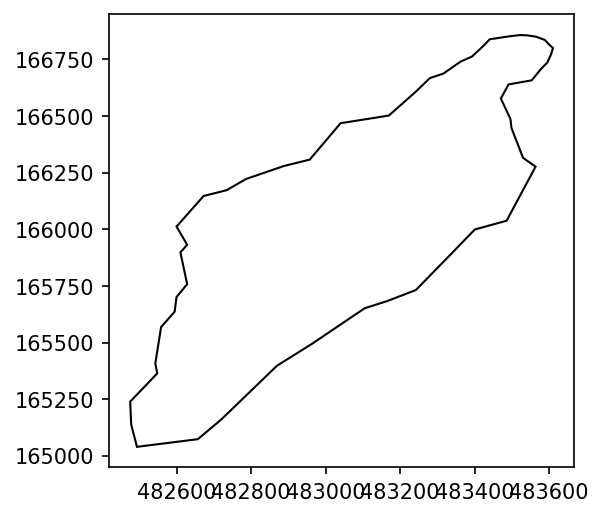

In [9]:
fig,ax = plt.subplots(1,1, figsize=(4,4))
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)

A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [10]:
# set up a dictionary of source objects
sources = workflow.source_list.get_default_sources()
sources['HUC'] = workflow.source_list.huc_sources['NHD Plus']
sources['hydrography'] = workflow.source_list.hydrography_sources['NHD Plus']
sources['DEM'] = workflow.source_list.dem_sources['NED 1/3 arc-second']
workflow.source_list.log_sources(sources)

2021-10-21 16:11:37,795 - root - INFO: Using sources:
2021-10-21 16:11:37,795 - root - INFO: --------------
2021-10-21 16:11:37,796 - root - INFO: HUC: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2021-10-21 16:11:37,796 - root - INFO: hydrography: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2021-10-21 16:11:37,797 - root - INFO: DEM: National Elevation Dataset (NED)
2021-10-21 16:11:37,797 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2021-10-21 16:11:37,798 - root - INFO: geologic structure: GLHYMPS version 2.0
2021-10-21 16:11:37,798 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2016_Land_Cover_L48
2021-10-21 16:11:37,799 - root - INFO: soil thickness: None
2021-10-21 16:11:37,799 - root - INFO: meteorology: DayMet 1km


## import river shapes

This requires a custom line shapefile that can be generated by QGIS. Some steps for replicating:

1. open QGIS, and duplicate the watershed shapefile, export to a different file (new_watershed.shp). **Must convert WGS CRS to UTM based CRS**
2. Convert shapefile polygon to line object. `Vector-->Geometry tools--> Polygon to lines...`
3. Add custom line object. Draw on QGIS.
4. Open attribute table, and delete the original watershed shape.
5. Save the shapefile.

### Option 1--bring your own shape

In [32]:
# with fiona.open(river_shp, mode='r') as fid:
#     profile = fid.profile
# #     bounds = watershed.exterior().bounds
# #     bounds_crs = workflow.crs.from_fiona(profile['crs'])
# #     bounds = workflow.warp.bounds(bounds, bounds_crs, workflow.crs.from_fiona(profile['crs']))
#     reaches = [r for (i,r) in fid.items()]

# Watershed boundary and river must be in the same CRS.

# # convert to destination crs
# native_crs = workflow.crs.from_fiona(profile['crs'])
# if crs and not workflow.crs.equal(crs, native_crs):
#     for reach in reaches:
#         workflow.warp.shape(reach, native_crs, crs)
# else:
#     crs = native_crs

# # **convert to shapely, and merge multiple reach segments into single rivers**

# reaches_s = [workflow.utils.shply(reach) for reach in reaches]
# rivers_s = list([shapely.ops.linemerge(shapely.geometry.MultiLineString(reaches_s))])

# fig,ax = plt.subplots(1,1, figsize=(4,4))
# workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
# # workflow.plot.rivers(reaches_s, crs, ax=ax, color='red', linewidth=1)
# x,y = rivers_s[0].xy
# ax.plot(x,y, 'b', linewidth = 0.5)

# logging.info("Generate the river tree")
# rivers = workflow.hydrography.make_global_tree(rivers_s)

### Option 2 -- download river network

In [11]:
huc = "170300010605"
simplify = 5
rivers = True
if rivers:
    # download/collect the river network within that shape's bounds
    _, reaches = workflow.get_reaches(sources['hydrography'], huc, 
                                      watershed.exterior().bounds, crs, crs)
    # simplify and prune rivers not IN the shape, constructing a tree-like data structure
    # for the river network
    rivers = workflow.simplify_and_prune(watershed, reaches, filter=True, simplify=simplify, snap=True,
                                         cut_intersections=True)

else:
    rivers = list()
    workflow.split_hucs.simplify(coweeta, simplify)



2021-10-21 16:12:00,386 - root - INFO: 
2021-10-21 16:12:00,387 - root - INFO: Loading Hydrography
2021-10-21 16:12:00,387 - root - INFO: ------------------------------
2021-10-21 16:12:00,388 - root - INFO: Loading streams in HUC 170300010605
2021-10-21 16:12:00,388 - root - INFO:          and/or bounds (482475.0870087285, 165040.12088065807, 483610.63090678875, 166857.88512907742)
2021-10-21 16:12:00,391 - root - INFO:   Using Hydrography file "/Users/shua784/github/watershed-workflow/examples/data/hydrography/NHDPlus_H_1703_GDB/NHDPlus_H_1703.gdb"
2021-10-21 16:12:00,392 - root - INFO:   National Hydrography Dataset Plus High Resolution (NHDPlus HR): opening '/Users/shua784/github/watershed-workflow/examples/data/hydrography/NHDPlus_H_1703_GDB/NHDPlus_H_1703.gdb' layer 'NHDFlowline' for streams in '(482475.0870087285, 165040.12088065807, 483610.63090678875, 166857.88512907742)'
2021-10-21 16:12:01,216 - root - INFO:   Filtering reaches not in-network
2021-10-21 16:12:01,216 - root -

/opt/anaconda3/envs/workflow-021121/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


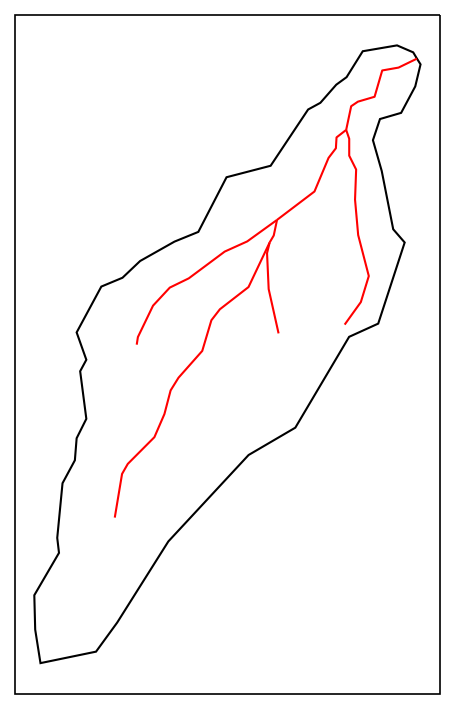

In [12]:
# plot what we have so far -- an image of the HUC and its stream network
fig = plt.figure(figsize=(8,6))
ax = workflow.plot.get_ax(crs, fig)

workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)

plt.show()

## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on interpolation between pixels of the DEM.

Note: 
- use `tol` to adjust the tolerance of minmium distance between two nodes.
- The triangles at the intersection between river and watershed will be extremely small, use `mesh_rivers = False`.
- For quasi-uniform meshes, try setting `d1` greater than the watershed length, and the mesh size will be close to `A0`

2021-10-21 16:12:07,453 - root - INFO: 
2021-10-21 16:12:07,454 - root - INFO: Meshing
2021-10-21 16:12:07,455 - root - INFO: ------------------------------
2021-10-21 16:12:07,482 - root - INFO: Triangulating...
2021-10-21 16:12:07,483 - root - INFO:    42 points and 42 facets
2021-10-21 16:12:07,484 - root - INFO:  checking graph consistency
2021-10-21 16:12:07,484 - root - INFO:  tolerance is set to 1
2021-10-21 16:12:07,485 - root - INFO:  building graph data structures
2021-10-21 16:12:07,486 - root - INFO:  triangle.build...
2021-10-21 16:12:07,486 - root - WARNING: Triangulate: '--enforce-delaunay' option requires a hacked `meshpy.triangle`.  Proceeding without this option because it is not recognized.
2021-10-21 16:12:09,024 - root - INFO:   ...built: 3130 mesh points and 6085 triangles
2021-10-21 16:12:09,025 - root - INFO: Plotting triangulation diagnostics
2021-10-21 16:12:09,399 - root - INFO:   min area = 15.959762573242188
2021-10-21 16:12:09,399 - root - INFO:   max area

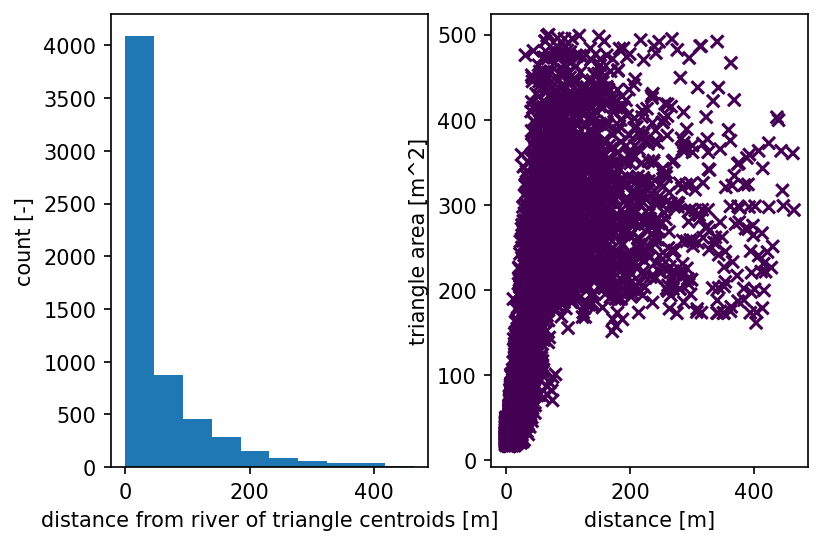

In [13]:
# form a triangulation on the shape + river network

# triangulation refinement:
# Refine triangles if their area (in m^2) is greater than A(d), where d is the 
# distance from the triangle centroid to the nearest stream.
# A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and
# linearly interpolates between the two endpoints.
d0 = 5; d1 = 20
# A0 = 10; A1 = 20 # [10, 1000]m
A0 = 50; A1 = 500 # [10, 1000]m
# A0 = 10000; A1 = 500000 # [100, 1000]m
# A0 = 100000; A1 = 5000000

# Refine triangles if they get too acute
min_angle = 32 # degrees

# make 2D mesh
mesh_points2, mesh_tris, areas, distances = workflow.triangulate(watershed, rivers,
                                               refine_distance=[d0,A0,d1,A1],
                                               refine_min_angle=min_angle,
                                               enforce_delaunay=True,
                                               diagnostics=True)
#mesh_points2, mesh_tris, d = workflow.triangulate(watershed, rivers,
#                                                 refine_max_area=100000,
#                                                 enforce_delaunay=True,
#                                                 diagnostics=True)

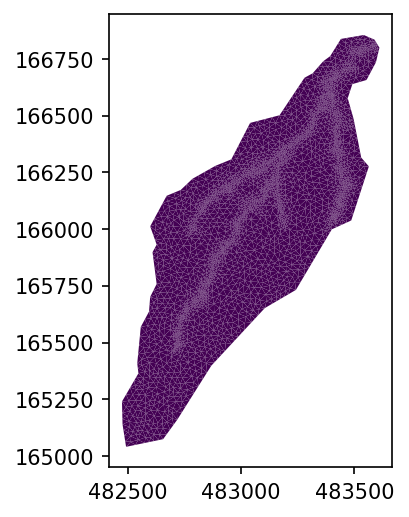

In [14]:
fig, ax = plt.subplots(1,1, figsize=(8, 4))
ax.set_aspect('equal')
ax.tripcolor(mesh_points2[:,0], mesh_points2[:,1], mesh_tris, facecolors= np.array([0]*len(mesh_tris)), 
                   cmap = None, edgecolors = 'w', linewidth=0.01)

## Import DEM

### Option 1--Bring your own DEM

In [38]:
# logging.info("import dem from {}".format(fname_dem))
# with rasterio.open(fname_dem, 'r') as fid:
#     dem_profile = fid.profile
#     dem = fid.read(1) # read the first band

2021-10-18 22:57:43,023 - root - INFO: import dem from /Users/shua784/OneDrive - PNNL/Projects/Fraser_hillslope/data/GIS/DEM/SecondGrowth.tif


### Option 2--Download DEM data from source

This download DEM from USGS NED with resolution of 1as (30 m).

In [15]:
# get a raster for the elevation map
dem_profile, dem = workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs)

2021-10-21 16:12:25,827 - root - INFO: 
2021-10-21 16:12:25,828 - root - INFO: Loading Raster
2021-10-21 16:12:25,829 - root - INFO: ------------------------------
2021-10-21 16:12:25,829 - root - INFO: Collecting raster
2021-10-21 16:12:26,029 - root - INFO: Collecting DEMs to tile bounds: [-120.739682313091, 46.80794161127143, -120.70485654214116, 46.84430625502627]
2021-10-21 16:12:26,033 - root - INFO:   Need:
2021-10-21 16:12:26,033 - root - INFO:     /Users/shua784/github/watershed-workflow/examples/data/dem/USGS_NED_13as_n47_w121.tif
2021-10-21 16:12:26,034 - root - INFO: source files already exist!
2021-10-21 16:12:26,073 - root - INFO: ... got raster of shape: (393, 377)
2021-10-21 16:12:26,083 - root - INFO: ... got raster bounds: (-120.739682313091, 46.84430625502627, -120.70477490568344, 46.80791736613722)


Smooth DEM if DEM-res is larger than average mesh-res, and there is artifical pits.

Text(0.5, 1.0, 'smoothed')

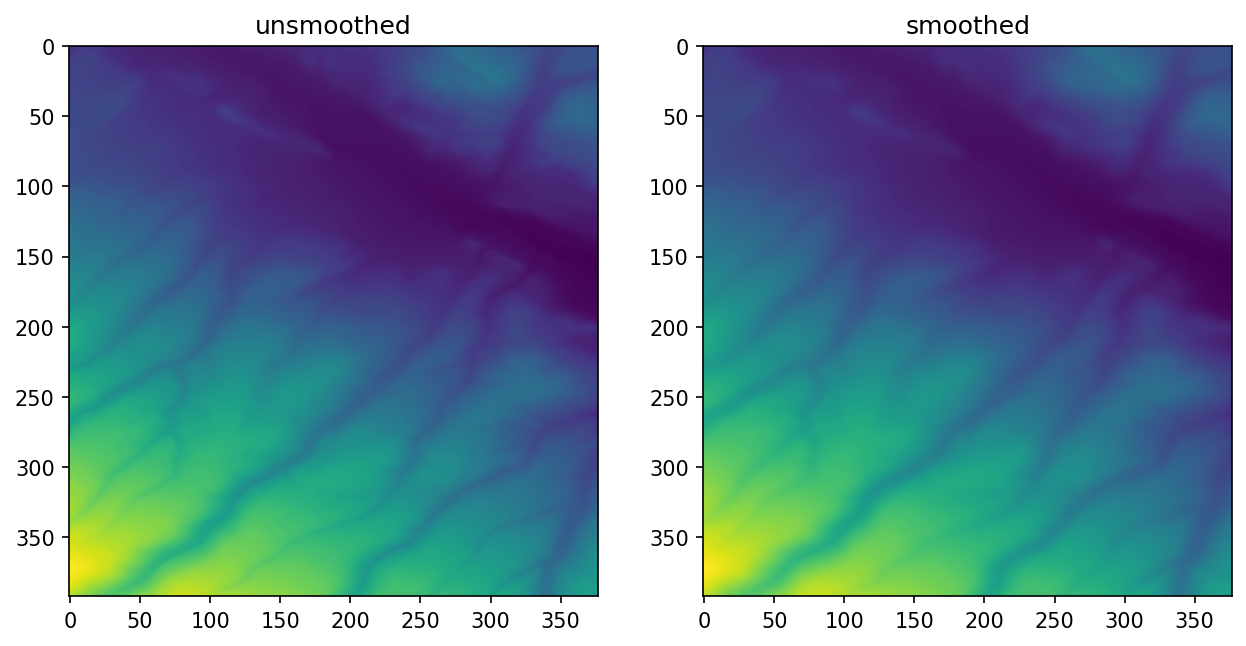

In [16]:
# noting that the DEM is a 30m raster, and we want to run at a coarser resolution of ~100-300m, 
# the DEM will look quite rough.  Smooth a small amount.  Note better algorithms could be used 
# here, but for now we just use Gaussian smoothing.
dem_sm = scipy.ndimage.gaussian_filter(dem, 2, mode='nearest')

fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(dem)
axs[0].set_title('unsmoothed')

axs[1].imshow(dem_sm)
axs[1].set_title('smoothed')


In [17]:
np.min(dem), np.max(dem)

(588.5586, 1026.6461)

In [18]:
np.min(dem_sm), np.max(dem_sm)

(589.3123, 1025.2238)

## elevate mesh to DEM

In [19]:
# elevate the triangle nodes to the dem
mesh_points3 = workflow.elevate(mesh_points2, crs, dem_sm, dem_profile, algorithm='piecewise bilinear')

2021-10-21 16:12:34,332 - root - INFO: 
2021-10-21 16:12:34,333 - root - INFO: Elevating Triangulation to DEM
2021-10-21 16:12:34,333 - root - INFO: ------------------------------


### plot surface mesh

Plotting the resulting mesh can be done in a variety of ways, including both 3D plots and mapview.  We show both here, but hereafter use mapview plots as they are a bit clearer (if not so flashy)...

[Text(164750.0, 0, ''),
 Text(165000.0, 0, ''),
 Text(165250.0, 0, ''),
 Text(165500.0, 0, ''),
 Text(165750.0, 0, ''),
 Text(166000.0, 0, ''),
 Text(166250.0, 0, ''),
 Text(166500.0, 0, ''),
 Text(166750.0, 0, ''),
 Text(167000.0, 0, '')]

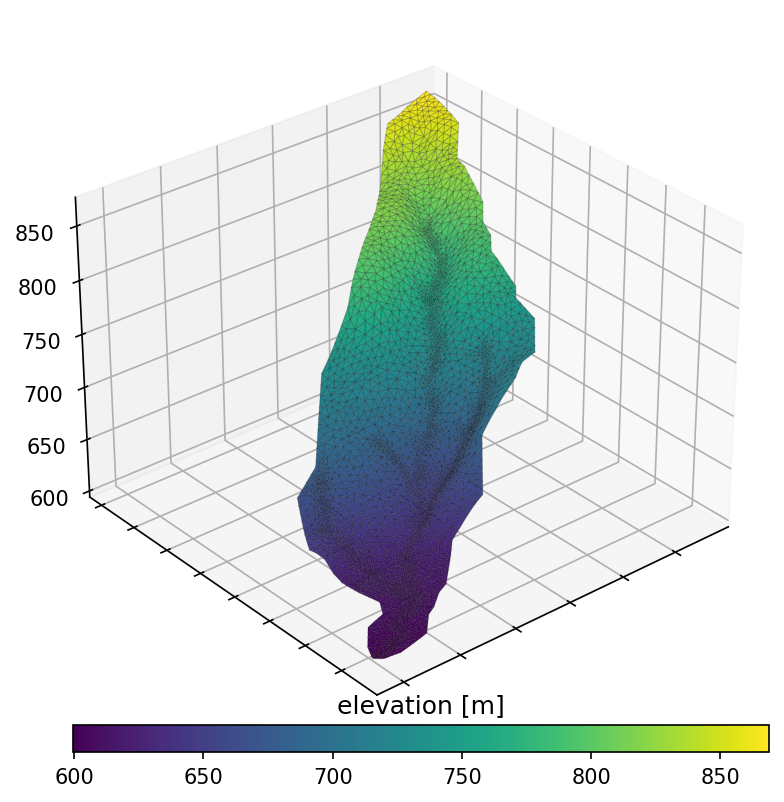

In [56]:
figsize = (6,6)
figsize_3d = (8,6)

# plot the resulting surface mesh
fig = plt.figure(figsize=figsize_3d)
ax = workflow.plot.get_ax('3d', fig, window=[0.0,0.2,1,0.8])
cax = fig.add_axes([0.23,0.18,0.58,0.03])

mp = ax.plot_trisurf(mesh_points3[:,0], mesh_points3[:,1], mesh_points3[:,2], 
                     triangles=mesh_tris, cmap='viridis', 
                     edgecolor=(0,0,0,.2), linewidth=0.5)
cb = fig.colorbar(mp, orientation="horizontal", cax=cax)

t = cax.set_title('elevation [m]')
ax.view_init(30,50)
ax.set_xticklabels(list())
ax.set_yticklabels(list())

#fig.savefig('watershed_dem_3d')

Text(0.5, 1.0, 'elevation [m]')

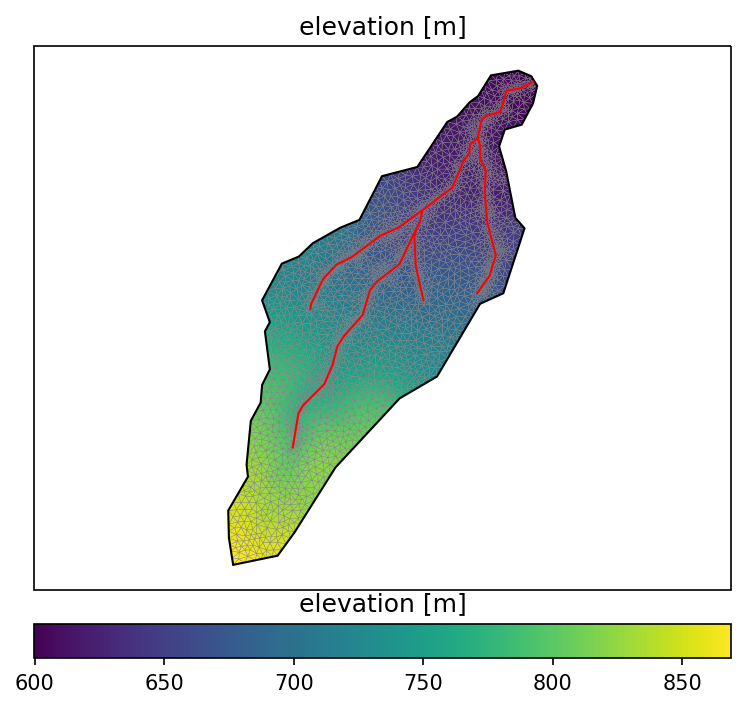

In [57]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color='elevation', edgecolor='gray', linewidth=0.2)
cbar = fig.colorbar(mp, orientation="horizontal", pad=0.05)
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)
ax.set_aspect('equal', 'datalim')
ax.set_title('elevation [m]')
cbar.ax.set_title('elevation [m]')
#fig.savefig('coweeta_dem')

### construct 2D mesh

In [20]:
m2 = workflow.mesh.Mesh2D(coords = mesh_points3.copy(), conn = list(mesh_tris))

### hydrologically conditioning the mesh in place by removing pits (optional)

In [21]:
# workflow.condition.condition(m2)

# hydrologically condition the mesh, removing pits
workflow.condition.fill_pits_dual(m2)

2021-10-21 16:12:40,598 - root - INFO: max diff = 1.1924124903973734


Text(0.5, 1.0, 'conditioned dz')

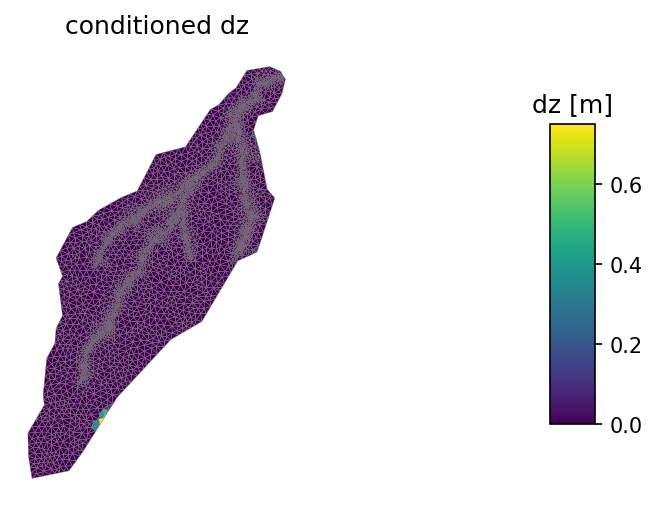

In [22]:
# plot the change between the two meshes
diff = np.copy(mesh_points3)
diff[:,2] = m2.coords[:,2] - mesh_points3[:,2] 
logging.info(f"max diff = {np.abs(diff[:,2]).max()}")

fig, ax = workflow.plot.get_ax(crs)
cbax = fig.add_axes([.95,0.25,0.05,0.5])
mp = workflow.plot.triangulation(diff, m2.conn, crs, color='elevation', edgecolors='gray', 
                            linewidth=0.2, ax=ax)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
cbar.ax.set_title('dz [m]')
ax.axis('off')
ax.set_title('conditioned dz')

### export surface mesh to VTK

In [23]:
m2.write_VTK(fname_surface_mesh)

## Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed.

In [25]:
# download the NLCD raster
# lc_profile, lc_raster = workflow.get_raster_on_shape(sources['land cover'], 
#                                                      watershed.exterior(), crs)
lc_profile, lc_raster = workflow.get_raster_on_shape("/Users/shua784/github/watershed-workflow/examples/data/land_cover/NLCD_2016_Land_Cover_L48/NLCD_2016_Land_Cover_L48.img", 
                                                     watershed.exterior(), crs)

# resample the raster to the triangles
lc = workflow.values_from_raster(m2.centroids(), crs, lc_raster, lc_profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(lc.dtype))
logging.info('Found land cover types: {}'.format(set(lc)))


2021-10-21 17:02:01,900 - root - INFO: 
2021-10-21 17:02:01,900 - root - INFO: Loading Raster
2021-10-21 17:02:01,901 - root - INFO: ------------------------------
2021-10-21 17:02:01,901 - root - INFO: Loading file: '/Users/shua784/github/watershed-workflow/examples/data/land_cover/NLCD_2016_Land_Cover_L48/NLCD_2016_Land_Cover_L48.img'
2021-10-21 17:02:01,902 - root - INFO: Collecting raster
2021-10-21 17:02:02,020 - root - INFO: bounds in my_crs: (-1873446.4214170938, 2892667.010940742, -1871915.1860080417, 2894166.9871320757)
2021-10-21 17:02:02,021 - root - INFO: ... got raster of shape: (51, 52)
2021-10-21 17:02:02,031 - root - INFO: ... got raster bounds: (-1873455.0, 2894175.0, -1871895.0, 2892645.0)
2021-10-21 17:02:02,166 - root - INFO: Found land cover dtypes: uint8
2021-10-21 17:02:02,167 - root - INFO: Found land cover types: {71, 42, 81, 52, 90}


(482418.3098, 483667.4082, 164949.31475000002, 166947.05225)

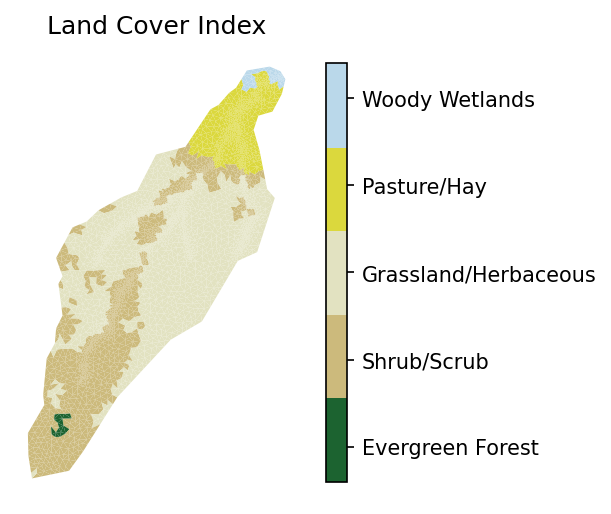

In [26]:
# plot the image
# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
                workflow.colors.generate_nlcd_colormap(lc)

fig, ax = workflow.plot.get_ax(crs)
polys = workflow.plot.mesh(m2, crs, ax=ax, color=lc, cmap=nlcd_cmap, norm=nlcd_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)

workflow.colors.colorbar_index(ncolors=len(np.unique(lc)), cmap=nlcd_cmap, labels = nlcd_labels) 

ax.set_title("Land Cover Index")
ax.axis('off')


## Subsurface properties

Get soil structure from SSURGO.  By soil structure, here we calculate, for each formation identified in SSURGO, a soil depth, porosity, permeability, and percent sand/silt/clay (which are then handed off to Rosetta to get a van Genuchten model). 

Below this soil we also identify a geologic layer provided by GLHYMPS.  This provides information about the deeper subsurface.

Finally, the bottom-most layer is bedrock, where we assume typical properties.

### SSURGO Soil Properties

Note there is missing data here, and some inconsistencies across map boundaries, which makes this data not always ideal.  We use these properties where they are available, and fill with other values as needed.  SSURGO cannot really be used in an automated way for this reason.

In [35]:
# download the NRCS soils data as shapes and project it onto the mesh

# -- download the shapes
target_bounds = watershed.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))
soil_profile, soil_survey, soil_survey_props = workflow.get_shapes(sources['soil structure'], 
                                                                   target_bounds, crs, crs, properties=True)

# -- determine the NRCS mukey for each soil unit; this uniquely identifies soil 
#    properties
soil_ids = np.array([shp.properties['mukey'] for shp in soil_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
soil_color_profile, soil_color_raster = \
            workflow.color_raster_from_shapes(target_bounds, 10, soil_survey,
                                              soil_ids, crs)

# -- resample the raster to the triangles
soil_color = workflow.values_from_raster(m2.centroids(), crs, 
                                         soil_color_raster, soil_color_profile)

2021-10-21 17:10:01,443 - root - INFO: target bounds: (482475.0870087285, 165040.12088065807, 483610.63090678875, 166856.24604072154)
2021-10-21 17:10:01,444 - root - INFO: 
2021-10-21 17:10:01,444 - root - INFO: Loading shapes
2021-10-21 17:10:01,445 - root - INFO: ------------------------------
2021-10-21 17:10:01,650 - root - INFO: Attempting to download source for target '/Users/shua784/github/watershed-workflow/examples/data/soil_structure/SSURGO/SSURGO_-120.7298_46.8178_-120.7147_46.8344.shp'
2021-10-21 17:10:01,654 - root - INFO:   Found 32 shapes.
2021-10-21 17:10:01,666 - root - INFO:   and crs: epsg:4326
2021-10-21 17:10:01,675 - root - INFO: found 14 unique MUKEYs.
2021-10-21 17:10:02,149 - root - INFO: Running Rosetta for van Genutchen parameters
2021-10-21 17:10:02,150 - root - INFO:   database: ../../watershed-workflow/workflow_tpls/rosetta/sqlite/Rosetta.sqlite
2021-10-21 17:10:02,151 - root - INFO:   model type: 3
2021-10-21 17:10:02,230 - root - INFO:   ... done
2021-1

In [36]:
soil_survey_props

,residual saturation [-],Rosetta porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],Rosetta permeability [m^2],mukey,thickness [cm],permeability [m^2],porosity [-],bulk density [g/cm^3],total sand pct [%],total silt pct [%],total clay pct [%],source
0,0.239901,0.472414,0.000073,1.350836,2.406729e-13,68891,36.000000,3.737193e-13,0.152000,1.270000,28.900000,34.400000,36.700000,NRCS
1,0.232636,0.449268,0.000064,1.384238,2.079313e-13,68893,64.250000,4.671889e-13,0.240691,1.301782,29.597760,40.061268,30.340972,NRCS
2,0.249420,0.474364,0.000073,1.335910,2.000189e-13,68896,152.000000,9.100000e-14,0.480658,1.296711,23.800000,35.387500,40.812500,NRCS
3,0.210494,0.432126,0.000071,1.416022,2.814947e-13,68938,152.000000,5.310052e-13,0.479079,1.297566,40.421711,37.601316,21.976974,NRCS
4,0.210494,0.432126,0.000071,1.416022,2.814947e-13,68939,152.000000,5.310052e-13,0.479079,1.297566,40.421711,37.601316,21.976974,NRCS
5,0.210494,0.432126,0.000071,1.416022,2.814947e-13,68940,152.000000,5.310052e-13,0.479079,1.297566,40.421711,37.601316,21.976974,NRCS
6,0.220997,0.443172,0.000067,1.400009,2.528580e-13,68941,108.500000,4.654696e-13,0.356424,1.287229,35.801069,38.200822,25.998109,NRCS
7,0.200440,0.408838,0.000076,1.431394,2.652646e-13,68975,152.000000,1.262479e-12,0.420658,1.360329,43.552632,38.720395,17.726974,NRCS
8,0.205727,0.424095,0.000073,1.423999,2.839838e-13,68988,81.000000,9.000000e-13,0.228125,1.314789,41.963380,37.945070,20.091549,NRCS
9,0.230725,0.358207,0.000089,1.356047,8.387599e-14,68989,104.666667,9.000000e-13,0.228125,1.603192,41.963380,37.945070,20.091549,NRCS


Select only the soils within the watershed

In [38]:
soil_survey_props.set_index('mukey', inplace=True, drop=False)
# only select soils that are mapped to the meshes
soil_survey_props = soil_survey_props.loc[np.unique(soil_color), :]

In [39]:
soil_survey_props

,residual saturation [-],Rosetta porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],Rosetta permeability [m^2],mukey,thickness [cm],permeability [m^2],porosity [-],bulk density [g/cm^3],total sand pct [%],total silt pct [%],total clay pct [%],source
mukey,,,,,,,,,,,,,,
68891,0.239901,0.472414,0.000073,1.350836,2.406729e-13,68891,36.00,3.737193e-13,0.152000,1.270000,28.900000,34.400000,36.700000,NRCS
68893,0.232636,0.449268,0.000064,1.384238,2.079313e-13,68893,64.25,4.671889e-13,0.240691,1.301782,29.597760,40.061268,30.340972,NRCS
68896,0.249420,0.474364,0.000073,1.335910,2.000189e-13,68896,152.00,9.100000e-14,0.480658,1.296711,23.800000,35.387500,40.812500,NRCS
68938,0.210494,0.432126,0.000071,1.416022,2.814947e-13,68938,152.00,5.310052e-13,0.479079,1.297566,40.421711,37.601316,21.976974,NRCS
68939,0.210494,0.432126,0.000071,1.416022,2.814947e-13,68939,152.00,5.310052e-13,0.479079,1.297566,40.421711,37.601316,21.976974,NRCS
68940,0.210494,0.432126,0.000071,1.416022,2.814947e-13,68940,152.00,5.310052e-13,0.479079,1.297566,40.421711,37.601316,21.976974,NRCS
68975,0.200440,0.408838,0.000076,1.431394,2.652646e-13,68975,152.00,1.262479e-12,0.420658,1.360329,43.552632,38.720395,17.726974,NRCS
69000,0.160710,0.420794,0.000039,1.590572,6.345616e-13,69000,162.00,9.000000e-13,0.485494,1.279630,23.084568,67.977160,8.938272,NRCS
69045,0.234947,0.443083,0.000060,1.389083,1.809737e-13,69045,152.00,3.466573e-13,0.135855,1.324868,27.000658,42.877632,30.121711,NRCS


Clean up the table by replacing Nans, reorganize columns

In [199]:
# Note the missing data (white).  This is because some SSURGO map units have no formation with complete 
# information.  So we merge the above available data, filling where possible and dropping regions that
# do not have a complete set of properties.
soil_survey_props_clean = soil_survey_props.copy()

# later scripts expect 'native_index' as a standard name of holding onto the original IDs
# soil_survey_props_clean.rename_axis('native_index', inplace=True)
soil_survey_props_clean.rename(columns={'mukey':'native_index'}, inplace=True)

# need thickness in m
soil_survey_props_clean['thickness [cm]'] = soil_survey_props_clean['thickness [cm]']/100.
soil_survey_props_clean.rename(columns={'thickness [cm]':'thickness [m]'}, inplace=True)


def replace_column_nans(df, col_nan, col_replacement):
    """In a df, replace col_nan entries by col_replacement if is nan.  In Place!"""
    row_indexer = df[col_nan].isna()
    df.loc[row_indexer, col_nan] = df.loc[row_indexer, col_replacement]
    return

# where poro or perm is nan, put Rosetta poro
replace_column_nans(soil_survey_props_clean, 'porosity [-]', 'Rosetta porosity [-]')
replace_column_nans(soil_survey_props_clean, 'permeability [m^2]', 'Rosetta permeability [m^2]')

# drop unnecessary columns
for col in ['Rosetta porosity [-]', 'Rosetta permeability [m^2]', 'bulk density [g/cm^3]', 'total sand pct [%]',
            'total silt pct [%]', 'total clay pct [%]']:
    soil_survey_props_clean.pop(col)
    

In [200]:
soil_survey_props_clean

,residual saturation [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],native_index,thickness [m],permeability [m^2],porosity [-],source
mukey,,,,,,,,
68891,0.239901,0.000073,1.350836,68891,0.3600,3.737193e-13,0.152000,NRCS
68893,0.232636,0.000064,1.384238,68893,0.6425,4.671889e-13,0.240691,NRCS
68896,0.249420,0.000073,1.335910,68896,1.5200,9.100000e-14,0.480658,NRCS
68938,0.210494,0.000071,1.416022,68938,1.5200,5.310052e-13,0.479079,NRCS
68939,0.210494,0.000071,1.416022,68939,1.5200,5.310052e-13,0.479079,NRCS
68940,0.210494,0.000071,1.416022,68940,1.5200,5.310052e-13,0.479079,NRCS
68975,0.200440,0.000076,1.431394,68975,1.5200,1.262479e-12,0.420658,NRCS
69000,0.160710,0.000039,1.590572,69000,1.6200,9.000000e-13,0.485494,NRCS
69045,0.234947,0.000060,1.389083,69045,1.5200,3.466573e-13,0.135855,NRCS


In [201]:
def rm_duplicates(df, cols = ['permeability [m^2]', 'porosity [-]']):
    """find the duplicates based on perm and porosity."""
    
    # round up the decimals to remove the duplicates
    df['permeability [m^2]'] = df['permeability [m^2]'].apply(lambda x: f'{x: 0.2e}')
    df['permeability [m^2]'] = pd.to_numeric(df['permeability [m^2]'])
    df['porosity [-]'] = df['porosity [-]'].round(2)
    
    dup_df = df[df.duplicated(subset = cols, keep = False)].copy()

    idx = list(dup_df.index)
    
    if len(idx) > 0:
        unique_idx = list(dup_df.drop_duplicates(subset=cols).index)

        dup_list = {}
        for i in unique_idx:
            ids = []
            for j in idx:
                if j != i and (df.loc[j, cols] == df.loc[i, cols]).all():
                    ids.append(j)

            dup_list[i] = ids

        drop_idx = sum(dup_list.values(), [])


        df.drop(labels = drop_idx, inplace = True)
    
        return df, dup_list

In [202]:
soil_survey_props_clean, dup_list = rm_duplicates(soil_survey_props_clean)
soil_survey_props_clean

,residual saturation [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],native_index,thickness [m],permeability [m^2],porosity [-],source
mukey,,,,,,,,
68891,0.239901,0.000073,1.350836,68891,0.3600,3.740000e-13,0.15,NRCS
68893,0.232636,0.000064,1.384238,68893,0.6425,4.670000e-13,0.24,NRCS
68896,0.249420,0.000073,1.335910,68896,1.5200,9.100000e-14,0.48,NRCS
68938,0.210494,0.000071,1.416022,68938,1.5200,5.310000e-13,0.48,NRCS
68975,0.200440,0.000076,1.431394,68975,1.5200,1.260000e-12,0.42,NRCS
69000,0.160710,0.000039,1.590572,69000,1.6200,9.000000e-13,0.49,NRCS
69045,0.234947,0.000060,1.389083,69045,1.5200,3.470000e-13,0.14,NRCS


In [204]:
# drop nans
soil_survey_props_clean.dropna(inplace=True)
soil_survey_props_clean.reset_index(drop=True, inplace=True)
soil_survey_props_clean

,residual saturation [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],native_index,thickness [m],permeability [m^2],porosity [-],source
0,0.239901,0.000073,1.350836,68891,0.3600,3.740000e-13,0.15,NRCS
1,0.232636,0.000064,1.384238,68893,0.6425,4.670000e-13,0.24,NRCS
2,0.249420,0.000073,1.335910,68896,1.5200,9.100000e-14,0.48,NRCS
3,0.210494,0.000071,1.416022,68938,1.5200,5.310000e-13,0.48,NRCS
4,0.200440,0.000076,1.431394,68975,1.5200,1.260000e-12,0.42,NRCS
5,0.160710,0.000039,1.590572,69000,1.6200,9.000000e-13,0.49,NRCS
6,0.234947,0.000060,1.389083,69045,1.5200,3.470000e-13,0.14,NRCS


In [205]:
# create a new soil_color, keeping on those that are kept here and re-indexing to ATS indices
# soil_color_new = -np.ones_like(soil_color)
soil_color_new = np.copy(soil_color)
for key, val in dup_list.items():
    for i in val:
        soil_color_new[np.where(soil_color_new == i)] = key

In [206]:
for new_id, old_id in enumerate(soil_survey_props_clean['native_index']):
    soil_color_new[np.where(soil_color_new == old_id)] = 1000+new_id

/opt/anaconda3/envs/workflow-021121/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


(482418.3098, 483667.4082, 164949.31475000002, 166947.05225)

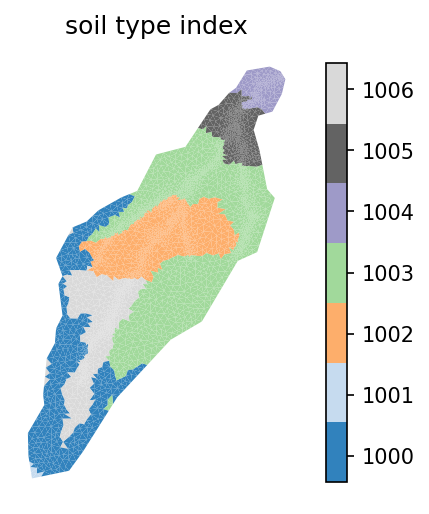

In [207]:
    
# image the new soil_color
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(soil_color_new, cmap='tab20c')
fig, ax = workflow.plot.get_ax(crs)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_color_new, 
                        cmap=cmap, norm=norm)

workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color_new)), cmap=cmap, labels=labels) 

ax.set_title('soil type index')
ax.axis('off')

Median soil thickness [-] =  1.52


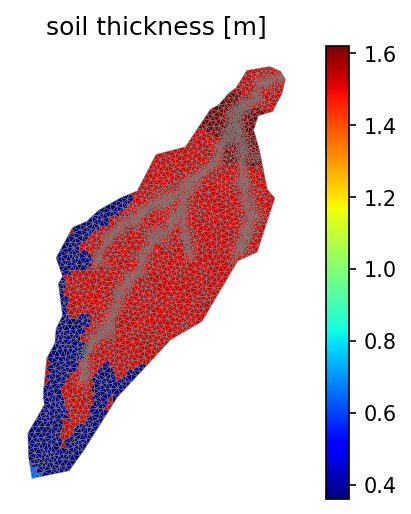

In [74]:
# what does soil thickness look like?
iprop = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    iprop[soil_color == mukey] = soil_survey_props.loc[mukey,'thickness [cm]']

iprop = iprop / 100
fig, ax = workflow.plot.get_ax(crs)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=iprop, edgecolor='gray', cmap='jet')
ax.set_title('soil thickness [m]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04)
ax.axis('off')

print('Median soil thickness [-] = ', np.nanmedian(iprop))

Median porosity [-] =  0.479078947368421


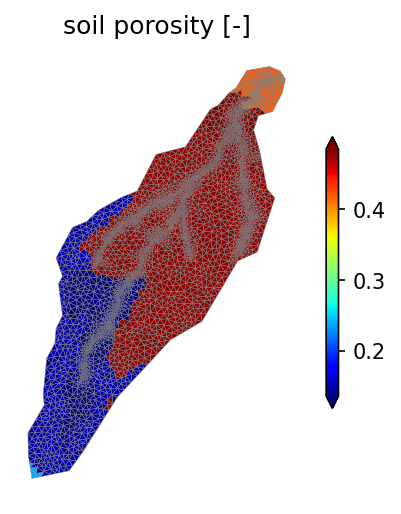

In [75]:
# plot of porosity from SSURGO
iprop = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    iprop[soil_color == mukey] = soil_survey_props.loc[ mukey,'porosity [-]']

fig, ax = workflow.plot.get_ax(crs)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=iprop, edgecolor='gray', cmap='jet')
ax.set_title('soil porosity [-]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04, extend = "both", shrink = 0.6)
ax.axis('off')

print('Median porosity [-] = ', np.nanmedian(iprop))

Min k [m^2] =  9.1e-14


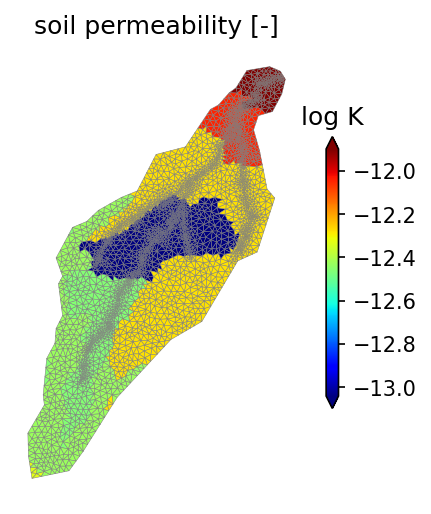

In [76]:
# plot of permeability
iprop = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    iprop[soil_color == mukey] = soil_survey_props.loc[ mukey,'permeability [m^2]']

fig, ax = workflow.plot.get_ax(crs)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=np.log10(iprop), edgecolor='gray', cmap='jet')
ax.set_title('soil permeability [-]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04, extend = "both", shrink = 0.6)
cb.ax.set_title('log K')
ax.axis('off')

print('Min k [m^2] = ', np.nanmin(iprop))

### GLYHMPS geologic layer

GLYHMPS is complete in that it does not appear to have missing data, but does not have texture properties needed for Water Retention Models.

In [178]:
# extract the GLYHMPS geologic structure data as shapes and project it onto the mesh
target_bounds = watershed.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))

_, geo_survey, geo_survey_props = workflow.get_shapes(sources['geologic structure'], 
                                                      target_bounds, crs, crs, properties=True)

# -- log the bounds targeted and found
logging.info('shape union bounds: {}'.format(
    shapely.ops.cascaded_union(geo_survey).bounds))

# -- determine the ID for each soil unit; this uniquely identifies formation
#    properties
geo_ids = np.array([shp.properties['id'] for shp in geo_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
geo_color_profile, geo_color_raster = \
            workflow.color_raster_from_shapes(target_bounds, 10, geo_survey,
                                              geo_ids, crs)

# -- resample the raster to the triangles
geo_color = workflow.values_from_raster(m2.centroids(), crs, 
                                         geo_color_raster, geo_color_profile)


2021-10-22 22:42:14,226 - root - INFO: target bounds: (482475.0870087285, 165040.12088065807, 483610.63090678875, 166856.24604072154)
2021-10-22 22:42:14,226 - root - INFO: 
2021-10-22 22:42:14,227 - root - INFO: Loading shapes
2021-10-22 22:42:14,227 - root - INFO: ------------------------------
2021-10-22 22:42:14,228 - root - INFO: Getting shapes of GLHYMPS on bounds: (482475.0870087285, 165040.12088065807, 483610.63090678875, 166856.24604072154)
2021-10-22 22:42:14,228 - root - INFO:   from file: /Users/shua784/github/watershed-workflow/examples/data/soil_structure/GLHYMPS/GLHYMPS.shp
2021-10-22 22:42:14,393 - fiona.ogrext - INFO: Failed to auto identify EPSG: 7
../../watershed-workflow/workflow/sources/manager_shape.py:85: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  shps = [s for (i,s) in fid.items(bbox=bounds)]
2021-10-22 22:42:35,458 - root - INFO: ... found 4 shapes
2021-10-22 22:42:35,458 - root

In [180]:
# select the properties that appear in the mesh
geo_survey_props.set_index('id', inplace=True, drop=False)
geo_survey_props = geo_survey_props.loc[np.unique(geo_color), :]

In [181]:
geo_survey_props

,id,source,permeability [m^2],logk_stdev [-],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-]
id,,,,,,,,
736758,736758,GLHYMPS,6.309573e-16,2.5,0.19,0.000025,2.0,0.01
736759,736759,GLHYMPS,1.000000e-13,2.0,0.22,0.000294,2.0,0.01
736836,736836,GLHYMPS,3.162278e-13,1.8,0.09,0.000817,2.0,0.01


In [208]:
# note there are clearly some common regions -- no need to duplicate those with identical values.
geo_survey_props_clean = geo_survey_props.copy()
geo_survey_props_clean.pop('logk_stdev [-]')
geo_survey_props_clean.rename(columns={'id':'native_index'}, inplace=True)


# def reindex_remove_duplicates(df, index=None):
#     """Removes duplicates, creating a new index and saving the old index as tuples of duplicate values. In place!"""
#     if index is not None:
#         if index in df:
#             df.set_index(index, drop=True, inplace=True)
    
#     index_name = df.index.name

#     # identify duplicate rows
#     duplicates = list(df.groupby(list(df)).apply(lambda x: tuple(x.index)))

#     # order is preserved
#     df.drop_duplicates(inplace=True)
#     df.reset_index(inplace=True)
#     df[index_name] = duplicates
#     return

# reindex_remove_duplicates(geo_survey_props_clean, 'native_index')
geo_survey_props_clean

,native_index,source,permeability [m^2],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-]
id,,,,,,,
736758,736758,GLHYMPS,6.309573e-16,0.19,0.000025,2.0,0.01
736759,736759,GLHYMPS,1.000000e-13,0.22,0.000294,2.0,0.01
736836,736836,GLHYMPS,3.162278e-13,0.09,0.000817,2.0,0.01


In [ ]:
# geo_survey_props_clean['van Genuchten alpha [Pa^-1]'] = [0.0001]

In [209]:
rm_duplicates(geo_survey_props_clean)

In [210]:
geo_survey_props_clean

,native_index,source,permeability [m^2],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-]
id,,,,,,,
736758,736758,GLHYMPS,6.310000e-16,0.19,0.000025,2.0,0.01
736759,736759,GLHYMPS,1.000000e-13,0.22,0.000294,2.0,0.01
736836,736836,GLHYMPS,3.160000e-13,0.09,0.000817,2.0,0.01


In [191]:
# drop nans
geo_survey_props_clean.dropna(inplace=True)
geo_survey_props_clean.reset_index(drop=True, inplace=True)
geo_survey_props_clean

,native_index,source,permeability [m^2],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-]
0,736758,GLHYMPS,6.31e-16,0.19,0.000025,2.0,0.01
1,736759,GLHYMPS,1.00e-13,0.22,0.000294,2.0,0.01
2,736836,GLHYMPS,3.16e-13,0.09,0.000817,2.0,0.01


/opt/anaconda3/envs/workflow-021121/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


(482418.3098, 483667.4082, 164949.31475000002, 166947.05225)

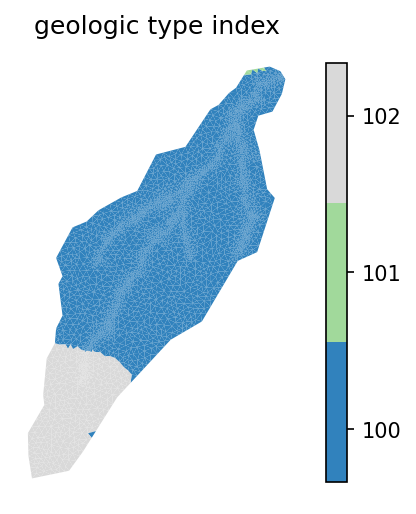

In [190]:
# create a new geologic layer color, keeping on those that are kept here and re-indexing to ATS indices
geo_color_new = -np.ones_like(geo_color)
for new_id, old_id in enumerate(geo_survey_props_clean['native_index']):
    geo_color_new[np.where(geo_color == old_id)] = 100+new_id
    
# image the new geo_color
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(geo_color_new, cmap='tab20c')
fig, ax = workflow.plot.get_ax(crs)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=geo_color_new, 
                        cmap=cmap, norm=norm)

workflow.colors.colorbar_index(ncolors=len(np.unique(geo_color_new)), cmap=cmap, labels=labels) 

ax.set_title('geologic type index')
ax.axis('off')

(482418.3098, 483667.4082, 164949.31475000002, 166947.05225)

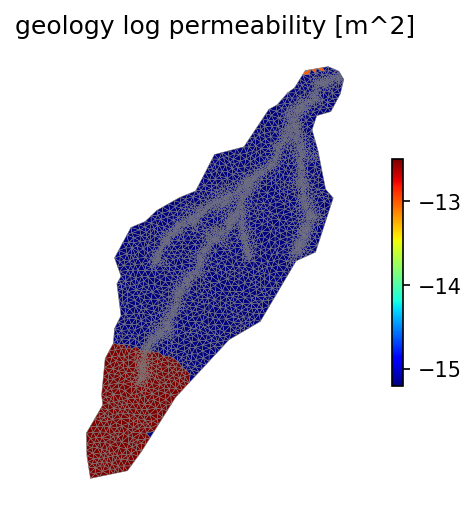

In [81]:
# plot permeability of the underlying geologic layer
iprop = np.empty(geo_color.shape, 'd')
for i in geo_survey_props.index:
    iprop[geo_color == i] = geo_survey_props.loc[i, 'permeability [m^2]']
    
fig, ax = workflow.plot.get_ax(crs)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=np.log10(iprop), edgecolor='gray', cmap='jet')
cbar = fig.colorbar(mp, shrink=0.5)
ax.set_title('geology log permeability [m^2]')
ax.axis('off')


(482418.3098, 483667.4082, 164949.31475000002, 166947.05225)

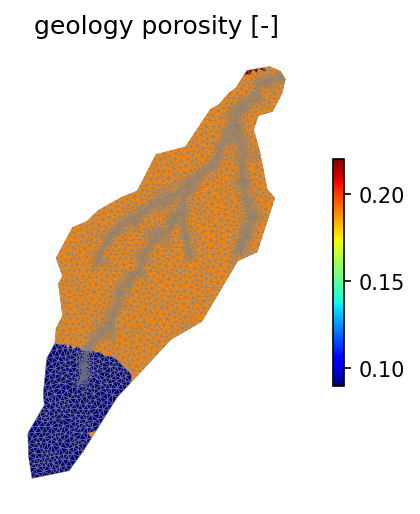

In [82]:
# plot porosity of the geologic layer
iprop = np.empty(geo_color.shape, 'd')
for i in geo_survey_props.index:
    iprop[geo_color == i] = geo_survey_props.loc[i, 'porosity [-]']

fig, ax = workflow.plot.get_ax(crs)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=iprop, edgecolor='gray', cmap='jet')
cbar = fig.colorbar(mp, shrink=0.5)
ax.set_title('geology porosity [-]')
ax.axis('off')


## Depth-to-bedrock

Depth to bedrock is taken from the [SoilGrids](http://globalchange.bnu.edu.cn/research/dtb.jsp) product.  Here we download a US-based, clipped version of this global product, as file sizes are quite large (all products potentially used total over 100GB).

In [215]:
# DTB_source = workflow.source_list.structure_sources['SoilGrids2017']
# DTB_profile, DTB_raster = workflow.get_raster_on_shape(DTB_source, watershed.exterior(), crs, 
#                                                        nodata=-99999, variable='BDTICM')
DTB_profile, DTB_raster = workflow.get_raster_on_shape("./data/soil_structure/depth-to-bedrock/Global_absoluteDTB_M_250m_ll.tif", 
                                                       watershed.exterior(), crs, nodata=-99999)

# resample the raster to the triangles
DTB_raster = DTB_raster/100 #convert from cm to m
DTB = workflow.values_from_raster(m2.centroids(), crs, DTB_raster, DTB_profile)
DTB = np.where(DTB >= 0, DTB, np.nan)

2021-10-22 23:07:19,562 - root - INFO: 
2021-10-22 23:07:19,563 - root - INFO: Loading Raster
2021-10-22 23:07:19,563 - root - INFO: ------------------------------
2021-10-22 23:07:19,564 - root - INFO: Loading file: './data/soil_structure/depth-to-bedrock/Global_absoluteDTB_M_250m_ll.tif'
2021-10-22 23:07:19,565 - root - INFO: Collecting raster
2021-10-22 23:07:19,716 - root - INFO: bounds in my_crs: (-120.72968231309099, 46.8179416103302, -120.71485654214116, 46.834306254085064)
2021-10-22 23:07:19,728 - root - INFO: ... got raster of shape: (8, 8)
2021-10-22 23:07:19,757 - root - INFO: ... got raster bounds: (-120.731259483, 46.834589819, -120.714592819, 46.817923155)


/opt/anaconda3/envs/workflow-021121/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


Text(0.5, 1.0, 'DTB [m]')

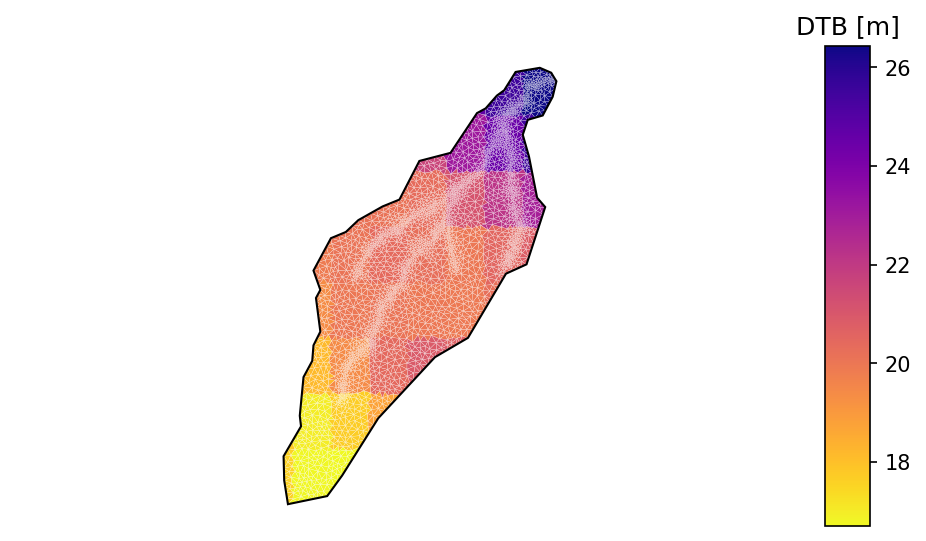

In [216]:
# plot the resulting surface mesh
fig, ax = workflow.plot.get_ax(crs, window=[0.05,0.1,0.9,0.8])
cbax = fig.add_axes([.95,0.1,0.05,0.8])

mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=DTB, cmap='plasma_r', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)

ax.set_aspect('equal', 'datalim')
ax.axis('off')

cbar.ax.set_title('DTB [m]')

## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

In [211]:
soil_survey_props_clean['ats_id'] = range(1000, 1000+len(soil_survey_props_clean))
soil_survey_props_clean.set_index('ats_id', inplace=True)

geo_survey_props_clean['ats_id'] = range(100, 100+len(geo_survey_props_clean))
geo_survey_props_clean.set_index('ats_id', inplace=True)

bedrock_props = workflow.soil_properties.get_bedrock_properties()

subsurface_props = pd.concat([geo_survey_props_clean, bedrock_props, soil_survey_props_clean])

In [212]:
subsurface_props

,native_index,source,permeability [m^2],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],thickness [m]
ats_id,,,,,,,,
100,736758.0,GLHYMPS,6.310000e-16,0.19,0.000025,2.000000,0.010000,NaN
101,736759.0,GLHYMPS,1.000000e-13,0.22,0.000294,2.000000,0.010000,NaN
102,736836.0,GLHYMPS,3.160000e-13,0.09,0.000817,2.000000,0.010000,NaN
999,NaN,n/a,1.000000e-16,0.15,0.000011,3.000000,0.010000,NaN
1000,68891.0,NRCS,3.740000e-13,0.15,0.000073,1.350836,0.239901,0.3600
1001,68893.0,NRCS,4.670000e-13,0.24,0.000064,1.384238,0.232636,0.6425
1002,68896.0,NRCS,9.100000e-14,0.48,0.000073,1.335910,0.249420,1.5200
1003,68938.0,NRCS,5.310000e-13,0.48,0.000071,1.416022,0.210494,1.5200
1004,68975.0,NRCS,1.260000e-12,0.42,0.000076,1.431394,0.200440,1.5200


In [213]:
subsurface_props.to_csv("/Users/shua784/github/wenas-creek/data/pre-processed/subsurface_prop.csv")

In [218]:
total_thickness = np.ceil(DTB.max())
logging.info(f'total thickness: {total_thickness} m')

2021-10-22 23:07:36,397 - root - INFO: total thickness: 27.0 m


In [96]:
# Generate a dz structure for the top 2m of soil
#
# here we try for 10 cells, starting at 5cm at the top and going to 50cm at the bottom of the 2m thick soil
# dzs, res = workflow.mesh.optimize_dzs(0.05, 0.5, 2, 5)
# print(dzs)
# print(sum(dzs))

[0.66666667 0.66666667 0.66666667]
2.0


In [219]:
dzs = [0.05, 0.45, 0.5, 1.0]

In [220]:
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

# -- soil layer --
for dz in dzs:
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(soil_color_new)
    
# -- geologic layer --
# keep going for 2m cells until we hit the bottom of
# the domain
dz = 2.0
geo_ncells = int(np.ceil((total_thickness- sum(dzs))/dz))
for i in range(geo_ncells):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(geo_color_new)

# print the summary
workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

2021-10-22 23:08:41,464 - root - INFO: Cell summary:
2021-10-22 23:08:41,465 - root - INFO: ------------------------------------------------------------
2021-10-22 23:08:41,465 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2021-10-22 23:08:41,466 - root - INFO: ------------------------------------------------------------
2021-10-22 23:08:41,466 - root - INFO:  00 	| 00 	| 1006 	|   0.050000 	|   0.000000
2021-10-22 23:08:41,467 - root - INFO:  01 	| 01 	| 1006 	|   0.450000 	|   0.050000
2021-10-22 23:08:41,467 - root - INFO:  02 	| 02 	| 1006 	|   0.500000 	|   0.500000
2021-10-22 23:08:41,468 - root - INFO:  03 	| 03 	| 1006 	|   1.000000 	|   1.000000
2021-10-22 23:08:41,468 - root - INFO:  04 	| 04 	|  102 	|   2.000000 	|   2.000000
2021-10-22 23:08:41,468 - root - INFO:  05 	| 05 	|  102 	|   2.000000 	|   4.000000
2021-10-22 23:08:41,469 - root - INFO:  06 	| 06 	|  102 	|   2.000000 	|   6.000000
2021-10-22 23:08:41,469 - root - INFO:  07 	| 07 	|  102 	|   2.000000 	|   8.0

Finally, we add the bedrock material.

In [221]:
# get depth of each layer
z_elev = np.cumsum(np.array([0] + dzs + [dz]*geo_ncells))
z_center = z_elev[:-1] + (z_elev[1:] - z_elev[:-1])/2

mat_ids = np.stack(layer_mat_ids)

for icol in np.arange(mat_ids.shape[1])[:]:
    idtb = DTB[icol]
    idx = z_center > idtb
    
    # assign 999 to bedrock
    mat_ids[idx, icol] = 999

layer_mat_ids = [mat_ids[row, :] for row in np.arange(mat_ids.shape[0])]

In [222]:
# extrude
m3 = workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

In [223]:
m3.num_cells()

103445

### add land cover sidesets (optional)

In [224]:
nlcd_labels

['Evergreen Forest',
 'Shrub/Scrub',
 'Grassland/Herbaceous',
 'Pasture/Hay',
 'Woody Wetlands']

In [225]:
# # add back on land cover side sets
surf_ss = m3.side_sets[1]

for index, name in zip(nlcd_indices, nlcd_labels):
    where = np.where(lc == index)[0]
    ss = workflow.mesh.SideSet(name, int(index), 
                            [surf_ss.elem_list[w] for w in where],
                            [surf_ss.side_list[w] for w in where])        
    m3.side_sets.append(ss)

## export mesh file

In [227]:
# save to disk
try:
    os.remove(fname_final_mesh)
except FileNotFoundError:
    pass
m3.write_exodus(fname_final_mesh)


You are using exodus.py v 1.19.1 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: ./meshes/wenas_catchment_mesh-10m.exo
Closing exodus file: ./meshes/wenas_catchment_mesh-10m.exo
